# West Nile Virus (WNV) Detection

In [360]:
#load the libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point, Polygon
import warnings 
warnings.filterwarnings('ignore')

# Data Anlysis

In [361]:
#load  the date
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
weather = pd.read_csv("weather.csv")
spray = pd.read_csv("spray.csv")

In [362]:
train.head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,5/29/2007,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,5/29/2007,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,5/29/2007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,5/29/2007,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,5/29/2007,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [363]:
#rows and cloumns in the training dataset
train.shape

(10506, 12)

In [364]:
train.info

<bound method DataFrame.info of             Date                                            Address  \
0      5/29/2007  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1      5/29/2007  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2      5/29/2007  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3      5/29/2007    7900 West Foster Avenue, Chicago, IL 60656, USA   
4      5/29/2007    7900 West Foster Avenue, Chicago, IL 60656, USA   
...          ...                                                ...   
10501  9/26/2013      5100 West 72nd Street, Chicago, IL 60638, USA   
10502  9/26/2013    5800 North Ridge Avenue, Chicago, IL 60660, USA   
10503  9/26/2013  1700 North Ashland Avenue, Chicago, IL 60622, USA   
10504  9/26/2013   7100 North Harlem Avenue, Chicago, IL 60631, USA   
10505  9/26/2013      4200 West 65th Street, Chicago, IL 60621, USA   

                      Species  Block           Street  Trap  \
0      CULEX PIPIENS/RESTUANS     41   N OAK PARK AV

In [365]:
#do we have any null values in the dataset?
train.isnull().sum(axis=0)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [366]:
#change datecolumn to datetime
train['Date'] = pd.to_datetime(train['Date'])
display(train.Date.sort_values().head(1))

0   2007-05-29
Name: Date, dtype: datetime64[ns]

How often does city of Chicago count the mosquiotes?

In [367]:
print(train['Date'].dt.year.unique())
print(train['Date'].dt.month.unique())
print(train['Date'].dt.day.unique())
print (len(train.Date.unique()))

[2007 2009 2011 2013]
[ 5  6  7  8  9 10]
[29  5 26  2 11 18 19 25 27  1  3  7  8  9 15 16 17 21 22 24 28  4  6 12
 10 13 31 14 30 23]
95


From the above data we can see that the city of Chicago conducted the srvey on every 2 month from 2007 to 2013. It also shows that the surveys were mostly done between the month of may and october for 95 days.

In how many unique location did the city of Chicago collect the sample?

In [368]:
#dictinct address
print(len(train.Address.unique()))
train.Address.value_counts().head()

138


ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA    750
South Doty Avenue, Chicago, IL, USA                                     542
South Stony Island Avenue, Chicago, IL, USA                             314
4100 North Oak Park Avenue, Chicago, IL 60634, USA                      185
4200 West 127th Street, Alsip, IL 60803, USA                            183
Name: Address, dtype: int64

In [369]:
len(train.Trap.unique())

136

Mosquiotoes samples were collected from 136 unique areas in the city.

In [370]:
#trap id value counts
train.Trap.value_counts().head()

T900    750
T115    542
T138    314
T002    185
T135    183
Name: Trap, dtype: int64

problem? We have 138 unique locations and only 136 trap ids. We need to figure out if a single trap id has more than 1 location

In [371]:
Trap_address=train.groupby('Trap')['Address'].nunique()
Trap_address[Trap_address>1]

Trap
T009    2
T035    2
Name: Address, dtype: int64

As we can see the trap id T009 and T005 have 2 different locations. We need to find out what are they?

In [372]:
train[train.Trap=='T009'].Address.unique()

array(['9100 West Higgins Avenue, Chicago, IL 60656, USA',
       '9100 West Higgins Road, Rosemont, IL 60018, USA'], dtype=object)

In [373]:
train[train.Trap=='T005'].Address.unique()

array(['6000 West Roscoe Street, Chicago, IL 60634, USA'], dtype=object)

In [374]:
#distinct street
print(len(train.Street.unique()))

128


In [375]:
train.Street.value_counts().head()

 W OHARE AIRPORT       750
 S DOTY AVE            542
 S STONY ISLAND AVE    347
 S ASHLAND AVE         266
 N OAK PARK AVE        216
Name: Street, dtype: int64

In [376]:
#import plotly.express as px
#import plotly.graph_objects as go
MAPBOX_TOKEN ='pk.eyJ1Ijoic2FudG9zaHRhbXU0MiIsImEiOiJjbDBsbGxjbzYweHY3M2NrYzlzZjg5YWYxIn0.iLgnAIuXaMnHh4gCd-Fykg'

In [377]:
px.set_mapbox_access_token(MAPBOX_TOKEN)
fig = px.scatter_mapbox(train, lat = 'Latitude', lon  = 'Longitude',
                        size_max=20, zoom = 10)

fig.update_layout(title = 'sample collection point',
    autosize=False,
    width=900,
    height=700,)

fig.show()

# Analyzing Species

In [378]:
display(train.WnvPresent.value_counts())

0    9955
1     551
Name: WnvPresent, dtype: int64

How many species of mosquitos are present in the survey?

In [379]:
len(train.Species.unique())

7

There are altogether 7 species present in the survey.

Count the value of each species.

In [380]:
train.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

Find the WNV present in each species in the sample collected by the city of chicago.

In [381]:
species_vs_virus = train[['Species', 'WnvPresent']].groupby('Species', as_index = False).sum()
species_vs_virus

,Species,WnvPresent
0,CULEX ERRATICUS,0
1,CULEX PIPIENS,240
2,CULEX PIPIENS/RESTUANS,262
3,CULEX RESTUANS,49
4,CULEX SALINARIUS,0
5,CULEX TARSALIS,0
6,CULEX TERRITANS,0


Among the 7 species of mosquitoes, 4 of them do not contain WNV virus on them. Whereas, out of thre infected samples CLUEX PIPIENS species are the most infected 262 put of 2699(around 9%) of the sample followed by CULEX PIPIENS/RESTUANS with around 5% of the sample.

In [382]:
fig = px.bar(species_vs_virus, x = 'Species', y = 'WnvPresent')
fig.update_layout(
    title="West Nile Virus count vs Species",
    xaxis_title="Species",
    yaxis_title="West Nile Virus Present",)
fig.show()

In [383]:
#WNV present in percentage
display(train.WnvPresent.value_counts()/ len(train.WnvPresent))

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

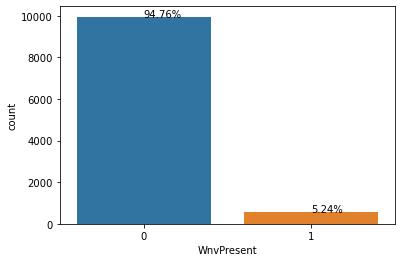

In [384]:
#plot
fig,  ax = plt.subplots(1,1)
sns.countplot(train['WnvPresent'], ax = ax)
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2,height,'{:.2f}{}'.format(height/len(train)*100,'%'))
plt.show()

Find out the percentage of WNV present in sample mosquitos by area.

In [385]:
#Computing percentage of wnv present in the moquitos counted at the given address 
Address_count=train.Address.value_counts()
Address_wnv=train.groupby('Address')['WnvPresent'].sum().sort_values(ascending=True)
Address_count=Address_count.to_frame().join(Address_wnv.to_frame())
Address_count = Address_count.rename(columns={'Address': 'Sample', 'WnvPresent': 'Wnv_sample'})
Address_count['Wnv_percent']=Address_count.Wnv_sample*100/Address_count.Sample
Address_count.sort_values(by='Wnv_percent',ascending=False).head()

,Sample,Wnv_sample,Wnv_percent
"6500 North Oak Park Avenue, Chicago, IL 60631, USA",31,6,19.354839
"6000 North Avondale Avenue, Chicago, IL 60631, USA",24,4,16.666667
"6000 West Roscoe Street, Chicago, IL 60634, USA",14,2,14.285714
"7100 North Harlem Avenue, Chicago, IL 60631, USA",50,7,14.000000
"6400 West Strong Street, Chicago, IL, USA",30,4,13.333333


From the above table we can see that mosquitos sample collected from 6500 North Oak Park Avenue area contains the highest percent of WNV (19.35%) followed by 6000 North Avondale Avenue which has 16.9% of WNV present in collected samples.        

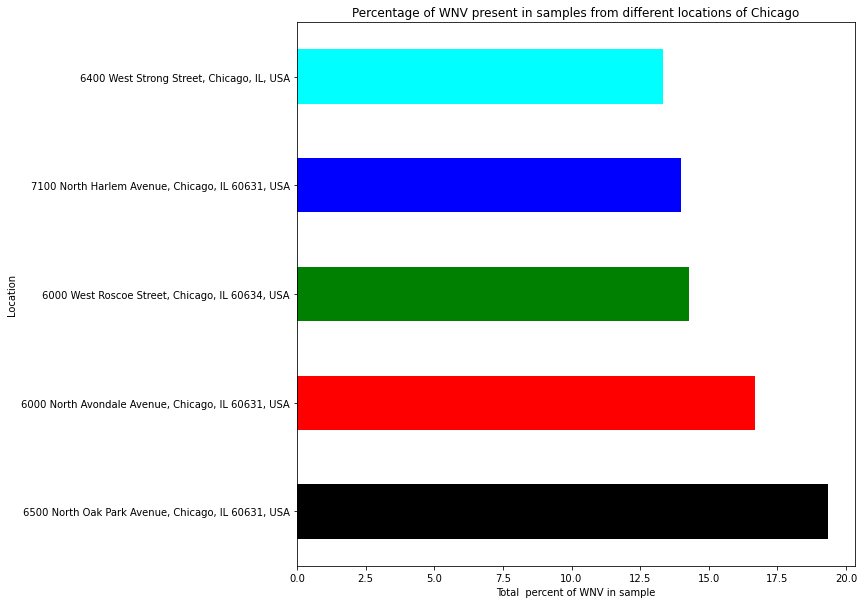

In [386]:
Address_count.Wnv_percent.sort_values(ascending= False).head(5).plot(kind='barh', figsize=(10, 10),  color=['black', 'red', 'green', 'blue', 'cyan'] ,  title='Percentage of WNV present in samples from different locations of Chicago')
plt.xlabel('Total  percent of WNV in sample')
plt.ylabel('Location')
plt.show()

# Plotting number of Mosquitos and areas where West Nile Virus is present

In [387]:
mosquito_count = train.groupby(['Address'], as_index = False)[['NumMosquitos']].sum()

In [388]:
areas = train.groupby(['Address'], as_index = False)[['Latitude','Longitude']].median()

In [389]:
wnv = train.groupby(['Address'], as_index = False)[['WnvPresent']].sum() 
# sum() because it has either 0 or 1 values. adding ones will give us total cases in an area.

In [390]:
mosquito_areas_wnv = pd.concat([mosquito_count,areas, wnv], axis = 1)

In [391]:
mosquito_areas_wnv.drop('Address', axis = 1, inplace = True)

In [392]:
fig = px.scatter_mapbox(mosquito_areas_wnv, lat = 'Latitude', lon  = 'Longitude', color = 'WnvPresent',
                        size = 'NumMosquitos', color_continuous_scale=px.colors.cyclical.IceFire,
                        hover_data = ['NumMosquitos', 'WnvPresent'],
                       zoom = 9)
fig.show()

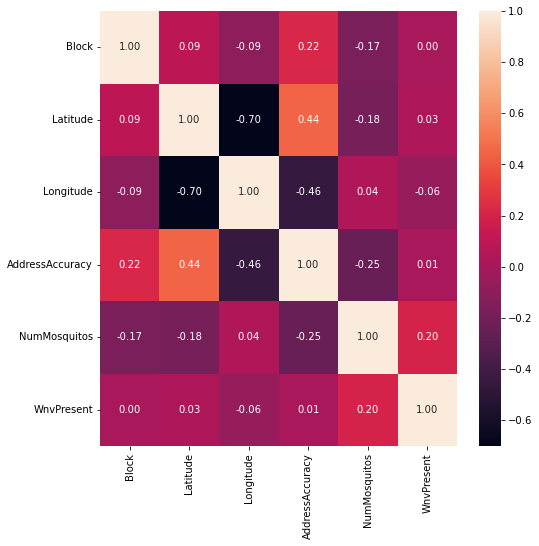

In [393]:
#Visualize correlation of target variable WnvPresent with other feathures
plt.subplots(figsize=(8,8))

corr = train.corr(method='pearson')
#sns.heatmap(dfweather_station[weather_features].corr());
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

# Analyzing impact of weather on mosquitos WNV present 

In [394]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,5/1/2007,83,50,67,14,51,56,0,2,...,,0,M,0,0,29.1,29.82,1.7,27,9.2
1,2,5/1/2007,84,52,68,M,51,57,0,3,...,,M,M,M,0,29.18,29.82,2.7,25,9.6
2,1,5/2/2007,59,42,51,-3,42,47,14,0,...,BR,0,M,0,0,29.38,30.09,13.0,4,13.4
3,2,5/2/2007,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0,29.44,30.08,13.3,2,13.4
4,1,5/3/2007,66,46,56,2,40,48,9,0,...,,0,M,0,0,29.39,30.12,11.7,7,11.9


In [395]:
weather.shape

(2944, 22)

In [396]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [397]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [398]:
weather.isin(['?']).sum(axis=0)

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [399]:
weather.isin(['-']).sum(axis=0)

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           0
Heat              0
Cool              0
Sunrise        1472
Sunset         1472
CodeSum           0
Depth             0
Water1            0
SnowFall          0
PrecipTotal       0
StnPressure       0
SeaLevel          0
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [400]:
weather.isin(['M']).sum(axis=0)

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [401]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [402]:
#Drop Water1 columns having entire missing values
weather=weather.drop(columns=['Water1'], axis = 1)

In [403]:
weather.isin(['  T']).sum(axis=0)

Station          0
Date             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
WetBulb          0
Heat             0
Cool             0
Sunrise          0
Sunset           0
CodeSum          0
Depth            0
SnowFall        12
PrecipTotal    318
StnPressure      0
SeaLevel         0
ResultSpeed      0
ResultDir        0
AvgSpeed         0
dtype: int64

In [404]:
weather.PrecipTotal.value_counts()

0       1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
3.64       1
4.73       1
1.6        1
2.24       1
1.18       1
Name: PrecipTotal, Length: 168, dtype: int64

In [405]:
#Replace the trace value with the average between 0 and 0.01
weather["PrecipTotal"]=[0.005 if i=='  T' else i for i in weather.PrecipTotal]

In [406]:
#Replacing Missing, Trace and - values with nan
weather.replace('M', np.nan,inplace=True)
weather.replace('-', np.nan,inplace=True)

In [407]:
#Converting Date to datetime
weather['Date']=pd.to_datetime(weather['Date'])
#Checking unique dates having mosquitos count
print(weather['Date'].dt.year.unique())
print(weather['Date'].dt.month.unique())
print(len(weather.Date.unique()))

[2007 2008 2009 2010 2011 2012 2013 2014]
[ 5  6  7  8  9 10]
1472


In [408]:
#Checking the number of weather stations
weather.Station.unique()

array([1, 2], dtype=int64)

Separating and merging weather parameters from two stations

In [409]:
#Seprating station1 and station2
weather_station1 =weather[weather['Station'] == 1]
weather_station2 =weather[weather['Station'] == 2]

In [410]:
weather_station1 =weather_station1.drop(columns=['Station'], axis = 1)
weather_station2 =weather_station2.drop(columns=['Station'], axis = 1)

In [411]:
#Merging station1 and station2
weather_station=weather_station1.merge(weather_station2,on='Date')

In [412]:
weather_station.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,Sunset_y,CodeSum_y,Depth_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,448,...,NaN,,NaN,NaN,0,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,447,...,NaN,BR HZ,NaN,NaN,0,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,446,...,NaN,HZ,NaN,NaN,0,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,444,...,NaN,,NaN,NaN,0,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,443,...,NaN,,NaN,NaN,0.005,29.46,30.09,11.2,7,11.5


In [413]:
weather_station.columns

Index(['Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x',
       'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x', 'CodeSum_x',
       'Depth_x', 'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x', 'SeaLevel_x',
       'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'Tmax_y', 'Tmin_y',
       'Tavg_y', 'Depart_y', 'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
       'Sunrise_y', 'Sunset_y', 'CodeSum_y', 'Depth_y', 'SnowFall_y',
       'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y', 'ResultSpeed_y',
       'ResultDir_y', 'AvgSpeed_y'],
      dtype='object')

In [414]:
#Removing columns having entire null values
weather_station=weather_station.drop(columns=['CodeSum_x','Depart_y','Sunrise_y',
             'Sunset_y','CodeSum_y','Depth_y'], axis = 1)

In [415]:
weather_station.head()


,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,WetBulb_y,Heat_y,Cool_y,SnowFall_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,448,...,57,0,3,NaN,0,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,447,...,47,13,0,NaN,0,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,446,...,50,7,0,NaN,0,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,444,...,50,NaN,NaN,NaN,0,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,443,...,50,5,0,NaN,0.005,29.46,30.09,11.2,7,11.5


In [416]:
#Checking object columns
weather_station.select_dtypes('object').columns

Index(['Tavg_x', 'Depart_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x',
       'Sunset_x', 'Depth_x', 'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x',
       'SeaLevel_x', 'AvgSpeed_x', 'Tavg_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
       'SnowFall_y', 'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y',
       'AvgSpeed_y'],
      dtype='object')

In [417]:
weather_station['Sunset'] = weather_station['Sunset_x'].map(lambda x: x[0:2]+':'+x[2:4])
weather_station.Sunset_x.unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1856', '1857',
       '1858', '1859', '1860', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
       '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
       '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
       '1930', '1931', '1900', '1854', '1848', '1846', '1845', '1843',
       '1842', '1840', '1839', '1837', '1835', '1834', '1832', '1831',
       '1829', '1827', '1826', '1824', '1822', '1821', '1819', '1817',
       '1815', '1814', '1812', '1810', '1809', '1807', '1805', '1803',
       '1760', '1758', '1756', '1755', '1753', '1751', '1749', '1748',
       '1746', '1744', '1742', '1741', '1739', '1737', '1735', '1734',
       '1732', '1730', '1729', '1727', '1725', '1724', '1722', '1720',
       '1719', '1717', '1715', '1714', '1712', '1711', '1709', '1707',
       '1706', '1704', '1703', '1701', '1660', '1658', '1657', '1656',
      

In [418]:
weather_station.Sunset_x.replace('1860','1900',inplace=True)
weather_station.Sunset_x.replace('1760','1800',inplace=True)
weather_station.Sunset_x.replace('1660','1700',inplace=True)

In [419]:
# Convert sunset into datetime format after inserting ':' in between hour and minute
weather_station['Sunset'] = weather_station['Sunset_x'].apply(lambda x: x[0:2]+':'+x[2:4])
weather_station['Sunset']=pd.to_datetime(weather_station.Sunset,format='%H:%M')-pd.to_datetime('1900-01-01 00:00:00')
weather_station.Sunset

0      0 days 18:49:00
1      0 days 18:50:00
2      0 days 18:51:00
3      0 days 18:52:00
4      0 days 18:53:00
             ...      
1467   0 days 16:53:00
1468   0 days 16:51:00
1469   0 days 16:50:00
1470   0 days 16:49:00
1471   0 days 16:47:00
Name: Sunset, Length: 1472, dtype: timedelta64[ns]

In [420]:
#Converting object columns to integer type
weather_station[['Tavg_x', 'Depart_x', 'WetBulb_x', 'Heat_x', 'Cool_x',
                   'WetBulb_y', 'Heat_y', 'Cool_y','Tavg_y'] ]=weather_station[['Tavg_x', 'Depart_x',
                   'WetBulb_x', 'Heat_x', 'Cool_x','WetBulb_y', 
                   'Heat_y', 'Cool_y','Tavg_y' ]].apply(pd.to_numeric)

In [421]:
#Converting object columns to float type
weather_station[['Depth_x', 'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x',
                   'PrecipTotal_y', 'StnPressure_y','SeaLevel_y', 'AvgSpeed_y'] ]=weather_station[['Depth_x',
                    'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x','PrecipTotal_y',
                    'StnPressure_y','SeaLevel_y', 'AvgSpeed_y' ]].apply(pd.to_numeric, downcast='float')

In [422]:
weather_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Date           1472 non-null   datetime64[ns] 
 1   Tmax_x         1472 non-null   int64          
 2   Tmin_x         1472 non-null   int64          
 3   Tavg_x         1472 non-null   int64          
 4   Depart_x       1472 non-null   int64          
 5   DewPoint_x     1472 non-null   int64          
 6   WetBulb_x      1469 non-null   float64        
 7   Heat_x         1472 non-null   int64          
 8   Cool_x         1472 non-null   int64          
 9   Sunrise_x      1472 non-null   object         
 10  Sunset_x       1472 non-null   object         
 11  Depth_x        1472 non-null   float32        
 12  SnowFall_x     1472 non-null   object         
 13  PrecipTotal_x  1472 non-null   float32        
 14  StnPressure_x  1470 non-null   float32        
 15  SeaL

In [424]:
weather_station['Tmax']=weather_station[['Tmax_x', 'Tmax_y']].mean(axis=1)
weather_station['Tmin']=weather_station[['Tmin_x', 'Tmin_y']].mean(axis=1)
weather_station['Tavg']=weather_station[['Tavg_x', 'Tavg_y']].mean(axis=1)
weather_station['DewPoint']=weather_station[['DewPoint_x', 'DewPoint_y']].mean(axis=1)
weather_station['WetBulb']=weather_station[['WetBulb_x', 'WetBulb_y']].mean(axis=1)
weather_station['Heat']=weather_station[['Heat_x', 'Heat_y']].mean(axis=1)
weather_station['Cool']=weather_station[['Cool_x', 'Cool_y']].mean(axis=1)
weather_station['PrecipTotal']=weather_station[['PrecipTotal_x', 'PrecipTotal_y']].mean(axis=1)
weather_station['StnPressure']=weather_station[['StnPressure_x', 'StnPressure_y']].mean(axis=1)
weather_station['SeaLevel']=weather_station[['SeaLevel_x', 'SeaLevel_y']].mean(axis=1)
weather_station['ResultSpeed']=weather_station[['ResultSpeed_x', 'ResultSpeed_y']].mean(axis=1)
weather_station['ResultDir']=weather_station[['ResultDir_x', 'ResultDir_y']].mean(axis=1)
weather_station['AvgSpeed']=weather_station[['AvgSpeed_x', 'AvgSpeed_y']].mean(axis=1)

In [425]:
weather_station.rename(columns = {'Depart_x':'Depart', 'Depth_x':'Depth'},  inplace = True)

In [426]:
weather_station.isnull().sum()

Date                0
Tmax_x              0
Tmin_x              0
Tavg_x              0
Depart              0
DewPoint_x          0
WetBulb_x           3
Heat_x              0
Cool_x              0
Sunrise_x           0
Sunset_x            0
Depth               0
SnowFall_x          0
PrecipTotal_x       0
StnPressure_x       2
SeaLevel_x          5
ResultSpeed_x       0
ResultDir_x         0
AvgSpeed_x          0
Tmax_y              0
Tmin_y              0
Tavg_y             11
DewPoint_y          0
WetBulb_y           1
Heat_y             11
Cool_y             11
SnowFall_y       1472
PrecipTotal_y       2
StnPressure_y       2
SeaLevel_y          4
ResultSpeed_y       0
ResultDir_y         0
AvgSpeed_y          3
Sunset              0
Tmax                0
Tmin                0
Tavg                0
DewPoint            0
WetBulb             0
Heat                0
Cool                0
PrecipTotal         0
StnPressure         1
SeaLevel            0
ResultSpeed         0
ResultDir 

In [427]:
def relative_humidity(Tavg,DewPoint):
    
    Tavg_celsius = (Tavg-32.0)/1.8
    DewPoint_celsius = (DewPoint-32.0)/1.8
    
    saturation_vapour_pressure = 6.11*10.0**(7.5*Tavg_celsius/(237.7+Tavg_celsius))
    actual_pressure = 6.11*10.0**(7.5*DewPoint_celsius/(237.7+DewPoint_celsius))
    
    return round(((actual_pressure/saturation_vapour_pressure)*100),2)

weather_station['Relative_humidity']=relative_humidity(weather_station.Tavg,weather_station.DewPoint)

In [428]:
weather_station=weather_station.drop(columns=['Tmax_x', 'Tmax_y','Tmin_x','Sunrise_x','Sunset_x', 'Tmin_y','Tavg_x', 'Tavg_y','DewPoint_x', 
                                                  'DewPoint_y','WetBulb_x', 'WetBulb_y','Heat_x', 'Heat_y','Cool_x', 
                                                  'Cool_y','PrecipTotal_x', 'PrecipTotal_y' ,'StnPressure_x', 'StnPressure_y',
                                                  'SeaLevel_x', 'SeaLevel_y','ResultSpeed_x', 'ResultSpeed_y','ResultDir_x',
                                                  'ResultDir_y','AvgSpeed_x', 'AvgSpeed_y'], axis = 1)

In [429]:
weather_station['DewPoint_depression']=weather_station.Tavg-weather_station.DewPoint
weather_station['WetBulb_depression']=weather_station.Tavg-weather_station.WetBulb

In [430]:
weather_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Date                 1472 non-null   datetime64[ns] 
 1   Depart               1472 non-null   int64          
 2   Depth                1472 non-null   float32        
 3   SnowFall_x           1472 non-null   object         
 4   SnowFall_y           0 non-null      object         
 5   Sunset               1472 non-null   timedelta64[ns]
 6   Tmax                 1472 non-null   float64        
 7   Tmin                 1472 non-null   float64        
 8   Tavg                 1472 non-null   float64        
 9   DewPoint             1472 non-null   float64        
 10  WetBulb              1472 non-null   float64        
 11  Heat                 1472 non-null   float64        
 12  Cool                 1472 non-null   float64        
 13  PrecipTotal       

In [431]:
#Unique values and their counts in Depth
print(weather_station.Depth.unique())
print(weather_station.Depth.value_counts())
weather_station=weather_station.drop(columns=['Depth'], axis = 1)

[0.]
0.0    1472
Name: Depth, dtype: int64


In [443]:
weather_station.head()

,Date,Depart,SnowFall_x,SnowFall_y,Sunset,Tmax,Tmin,Tavg,DewPoint,WetBulb,...,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Relative_humidity,DewPoint_depression,WetBulb_depression
0,2007-05-01,14,0,NaN,0 days 18:49:00,83.5,51.0,67.5,51.0,56.5,...,2.5,0.0000,29.139999,29.820000,2.20,26.0,9.400000,55.50,16.5,11.0
1,2007-05-02,-3,0,NaN,0 days 18:50:00,59.5,42.5,51.5,42.0,47.0,...,0.0,0.0000,29.410000,30.084999,13.15,3.0,13.400000,69.88,9.5,4.5
2,2007-05-03,2,0,NaN,0 days 18:51:00,66.5,47.0,57.0,40.0,49.0,...,0.0,0.0000,29.424999,30.120001,12.30,6.5,12.549999,52.92,17.0,8.0
3,2007-05-04,4,0,NaN,0 days 18:52:00,72.0,50.0,58.0,41.5,50.0,...,0.0,0.0025,29.334999,30.045000,10.25,7.5,10.600000,54.11,16.5,8.0
4,2007-05-05,5,0,NaN,0 days 18:53:00,66.0,53.5,60.0,38.5,49.5,...,0.0,0.0050,29.430000,30.095001,11.45,7.0,11.750000,44.83,21.5,10.5


In [444]:
weather_features = [x for x in weather_station.columns if x not in ['Date','Sunrise','Sunset','Daytime']]
weather_features

['Depart',
 'SnowFall_x',
 'SnowFall_y',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'Relative_humidity',
 'DewPoint_depression',
 'WetBulb_depression']

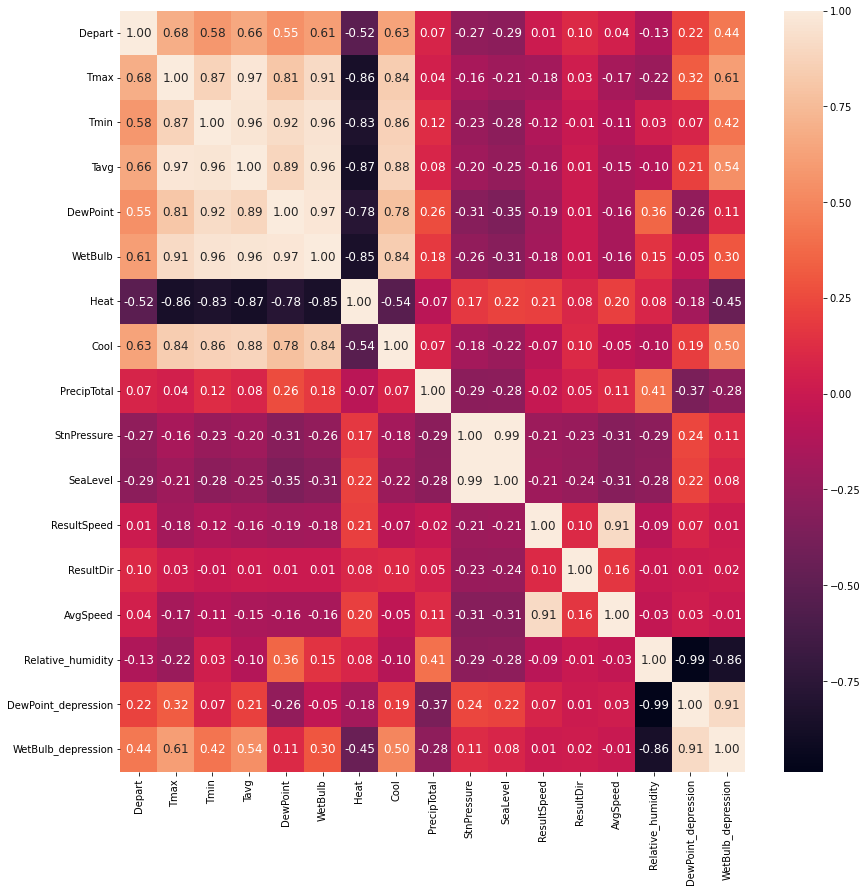

In [445]:
plt.subplots(figsize=(14,14))

corr = weather_station.corr(method='pearson')
#sns.heatmap(dfweather_station[weather_features].corr());
ax = sns.heatmap(corr, annot=True,annot_kws={'size':12}, fmt=".2f")
plt.savefig('heatmap.png',dpi=1200)

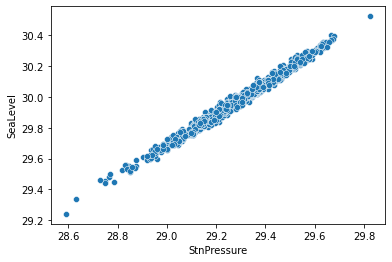

In [446]:
#Highly positive correlation coefficient 0.99  betweenStnPressure and SeaLevel. Similarly,  highly negative correlation coefficient -0.97 between Sunset and Sunrise. 
fig, ax = figsize=(15, 10)
sns.scatterplot(x='StnPressure',y='SeaLevel', data=weather_station)
plt.show()

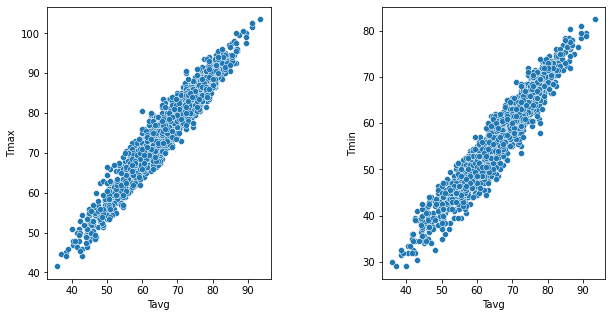

In [447]:
#Correlation coefficient of average temperature and maximum temperature is high 0.96. Similar value for average temperature and minimum temperature
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='Tavg',y='Tmax', data=weather_station,ax=ax[0])
sns.scatterplot(x='Tavg',y='Tmin', data=weather_station,ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.show()

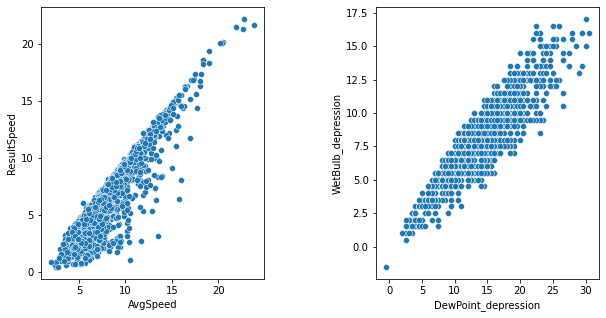

In [448]:
#AvgSpeed and ResultSpeed are highly correlated with 0.91. Same magnitude for DewPoint_depression and WetBulb_depression
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='AvgSpeed',y='ResultSpeed', data=weather_station,ax=ax[0])
sns.scatterplot(x='DewPoint_depression',y='WetBulb_depression', data=weather_station,ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.show()

In [437]:
#creating interactive correlation

Mosquitos and West Nile Virus are less prevalent on colder days. From the above clearly see that the WNV virus is more active on higher temperature. Similar analysis can be done on heat, precipitation etc.

   # Merge Training and Weather data

In [451]:
#Creating Dayofweek,Day week, month, year from date 
weather_station['Day_of_week']=weather_station['Date'].dt.dayofweek
weather_station['Day_of_month']=weather_station['Date'].dt.day
weather_station['Week']=weather_station['Date'].dt.isocalendar().week
weather_station['Month']=weather_station['Date'].dt.month
weather_station['Year']=weather_station['Date'].dt.year

In [452]:
def mkseason(n):
    if 3<=n<=5: season = 'Spring'
    elif 6<=n<=8: season = 'Summer'
    elif 9<=n<=11: season = 'Fall'
    else: season = 'Winter'
    return(season)

In [453]:
weather_station['Season'] = weather_station.Month.apply(mkseason)

In [454]:
def mkmonth(n):
    if n==5: month = 'May'
    elif n==6: month = 'June'
    elif n==7: month = 'July'
    elif n==8: month = 'Aug'
    elif n==9: month = 'Sep'   
    else: month = 'Oct'
    return(month)

In [455]:
weather_station['Monthofyear'] = weather_station.Month.apply(mkmonth)

In [460]:
#Merging training data with weather data on date
data1=train.merge(weather_station, on = 'Date')

In [461]:
data1.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,Relative_humidity,DewPoint_depression,WetBulb_depression,Day_of_week,Day_of_month,Week,Month,Year,Season,Monthofyear
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May


In [462]:
Yearly_count=data1.Year.value_counts()
Yearly_wnv=df.groupby('Year')['WnvPresent'].sum().sort_values(ascending=False)
Yearly_count=Yearly_count.to_frame().join(Yearly_wnv.to_frame())
Yearly_count = Yearly_count.rename(columns={'Year': 'Sample', 'WnvPresent': 'Wnv_sample'})
Yearly_count['Wnv_percent']=Yearly_count.Wnv_sample*100/Yearly_count.Sample
Yearly_count.reset_index(inplace=True)
Yearly_count=Yearly_count.rename(columns={'index': 'Year'})
dfgroup_yearly=Yearly_count.copy()
Yearly_count

,Year,Sample,Wnv_sample,Wnv_percent
0,2007,3811,236,6.192600
1,2013,2392,239,9.991639
2,2009,2249,19,0.844820
3,2011,2054,57,2.775073


# Analyzing effectiveness of spray

Areas where mosquito repellant was sprayed

In [463]:
px.set_mapbox_access_token(MAPBOX_TOKEN)

fig = px.scatter_mapbox(spray, lat = 'Latitude', lon  = 'Longitude',
                     animation_frame="Date",
                        size_max=15, zoom = 9)

fig.update_layout(
    title="Mosquito repellant sprayed area",
        width=900,
    height=700,
)

fig.show()

In [464]:
fig = px.scatter_mapbox(spray, lat = 'Latitude', lon  = 'Longitude',#animation_frame = 'Date',
                        size_max=15, zoom = 9,color_discrete_sequence=["palegoldenrod"],  opacity = 0.5)

fig2 = px.scatter_mapbox(mosquito_areas_wnv, lat = 'Latitude', lon  = 'Longitude', color = 'WnvPresent',
                        size = 'NumMosquitos', color_continuous_scale=px.colors.cyclical.IceFire,
                        hover_data = ['NumMosquitos', 'WnvPresent'],
                       zoom = 9)

fig.add_trace(fig2.data[0],)

fig.update_layout( title = 'Effeciveness of spray',
                width=900,
    height=700,
)

Areas that were sprayed, have very less virus cases but not spraying in correct areas caused cause more West Nile Virus cases.